In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys 
sys.path.insert(0, "../../..")

import warnings
warnings.filterwarnings("ignore")

from batchflow.opensets import PascalSegmentation
from batchflow import Batch, Pipeline, B, V, C, apply_parallel, ImagesBatch, action
from batchflow.models.torch import *
from batchflow.models.torch.layers import *

from torch.optim import Adam
import torch
import torch.nn.functional as F
import numpy as np

from configs import unet_config

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%autoreload 2

In [48]:
RESIZE = 256

BATCH_SIZE = 32
N_EPOCHS = 20
VAL_EVERY = 2
VAL_ITERS = 10

model_name = 'pascal_unet_dice'

In [4]:
class PascalBatch(ImagesBatch):
    components = 'images', 'masks'
    
    def __init__(self, index, *args, **kwargs):
        super().__init__(index, *args, **kwargs)
        self.inferred_masks = []
                    
    @apply_parallel(src='images', target='for')
    def resize_min_side(self, image, size, *args, **kwargs):
        h, w = image.size
        if h > w:
            new_size = (int(h * size / w), size)
        else:
            new_size = (size, int(w * size / h))
        
        return image.resize(new_size, *args, **kwargs)
    
    @apply_parallel(src='images', target='for') 
    def normalize(self, image, mean, std):
        return (image - mean) / (std + 1e-7) 
    
    @apply_parallel(src='masks', target='for')
     def squeeze_labels(self, image, enabled=True):
        if enabled:
            return image.squeeze()
        return image
    
    @apply_parallel(src='masks', target='for')
    def replace_background(self, image):
        image[image == 255] = 21.
        return image 
    
    @action 
    def eval_metrics(self):
        metrics = self.pipeline.get_variable('metrics')
        batch_metrics = metrics.evaluate(['accuracy', 'iou'], agg='mean')
        self.pipeline.set_variable('batch_accuracy', batch_metrics['accuracy'])
        self.pipeline.set_variable('batch_iou', batch_metrics['iou'])
        return self
             

In [5]:
dataset = PascalSegmentation(shuffle=True, batch_class=PascalBatch, path='../raw/pascal')

In [6]:
dataset.split(shares=0.8)

In [7]:
len(dataset.test), len(dataset.train)

(583, 2330)

In [8]:
def get_norm_stats(dataset, batch_size=64, channels='first'):
    ppl = dataset.p.to_array(src='images', dst='images')
    images = ppl.next_batch(batch_size).images
    mean = np.zeros(3)
    std = np.zeros(3)
    for i in range(batch_size):
        mean += images[i][..., 0].mean(), images[i][..., 1].mean(), images[i][..., 2].mean()
        std  += images[i][..., 0].std(), images[i][..., 1].std(), images[i][..., 2].std()
    if channels == 'first':
        mean = mean.reshape(3, 1, 1)
        std = std.reshape(3, 1, 1)
    return  mean / batch_size, std / batch_size

In [9]:
mean, std = get_norm_stats(dataset)  

preprocessing_template = (
                            Pipeline()
                            .resize_min_side(size=RESIZE, src='images', dst='images')  
                            .resize_min_side(size=RESIZE, src='masks', dst='masks')  
                            .crop(shape=(RESIZE, RESIZE), origin='center', src='images', dst='images')
                            .crop(shape=(RESIZE, RESIZE), origin='center', src='masks', dst='masks')
                            .to_array(src='images', dst='images', channels='first')
                            .to_array(src='masks', dst='masks', channels='first')
                            .normalize(mean=mean, std=std, src='images', dst='images')
                            .squeeze_labels(src='masks', dst='masks', enabled=False)
                            .replace_background(src='masks', dst='masks')
                        )

In [10]:
model_config = unet_config
model_config['head']['channels'] = 22
model_config['optimizer'] = {'name': 'Adam', 'lr': 1e-4}
model_config['loss'] = 'dice'

In [11]:
train_template = (  
    preprocessing_template +
    Pipeline()
        .init_variable('loss_history', [])
        .init_variable('IoU', [0])
        .init_variable('val_loss', [3])
        .init_model(name='model', model_class=TorchModel, config=model_config)

        .train_model('model',
                     inputs=B.images, targets=B.masks,
                     outputs='loss', save_to=V('loss_history', mode='a'))
)

In [12]:
train_pipeline = train_template << dataset.train

In [13]:
validation_template = (
        preprocessing_template +
        Pipeline()
        .init_variable('metrics')
        .init_variable('batch_accuracy', 0)
        .init_variable('batch_iou', 0)
        .init_variable('gather_accuracy', [])
        .init_variable('gather_iou', [])
        .init_variable('batch_inferred_masks')
        .init_variable('val_loss', [3])
        
        .import_model('model', train_pipeline)
        .predict_model('model',
                       inputs=B.images,
                       targets=B.masks,
                       outputs= ['predictions', 'loss'],
                       save_to=[V('batch_inferred_masks', mode='w'), V('val_loss', mode='a')]) 
    
        .gather_metrics('class', 
                        targets=B.masks,
                        predictions=V('batch_inferred_masks'),
                        fmt='logits',
                        axis=1,
                        num_classes=22, # model.num_ch
                        save_to=V('metrics', mode='u')
                       )
        .eval_metrics()
        .update(V('gather_accuracy', mode='a'), V('batch_accuracy'))
        .update(V('gather_iou', mode='a'), V('batch_iou'))
    )

In [14]:
train_notifier = {
    'bar': 'n', 'frequency': 10,
    'graphs': ['loss_history', 'val_loss', 'IoU'],
    'log_file': f'../saves/logs/{model_name}_notifier.txt'
}

In [15]:
validation_pipeline = validation_template << dataset.test

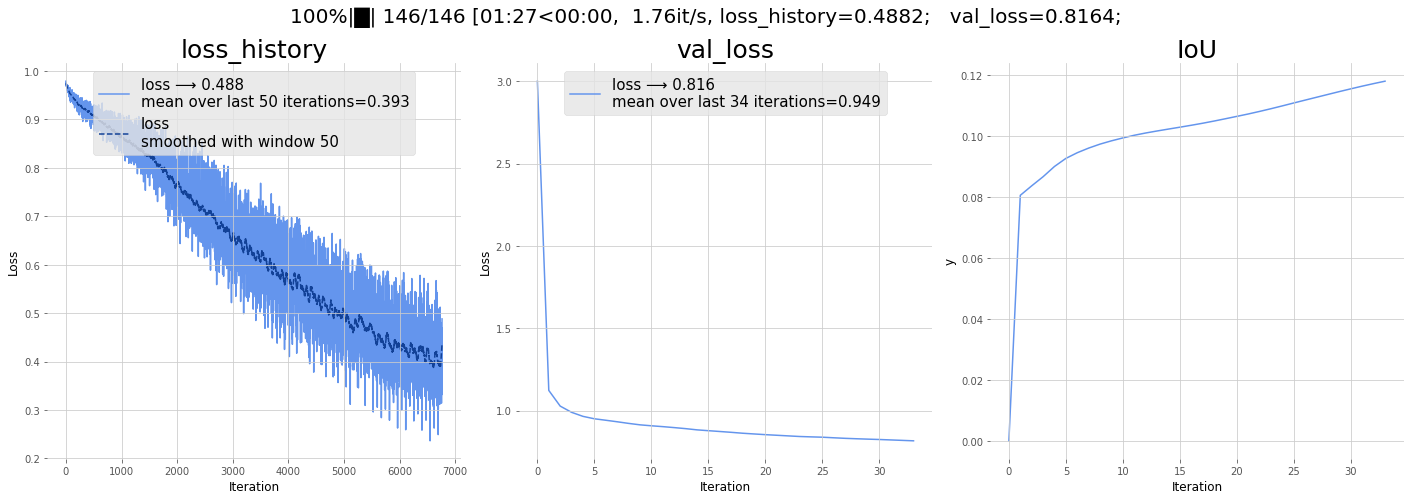

In [260]:
min_val_loss = 0.8

for _ in range(N_EPOCHS // VAL_EVERY):
    train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=VAL_EVERY, notifier=train_notifier)
    
    val_loss_history = train_pipeline.get_variable('val_loss')
    iou_history =  train_pipeline.get_variable('IoU')
    
    validation_pipeline.import_model('model', train_pipeline)
    validation_pipeline.run(batch_size=BATCH_SIZE, n_iters=VAL_ITERS)
    
    val_loss_history.append(np.mean(validation_pipeline.get_variable('val_loss')))
    iou_history.append(np.mean(validation_pipeline.get_variable('gather_iou')))
    
    train_pipeline.set_variable('val_loss', val_loss_history)
    train_pipeline.set_variable('IoU', iou_history)
    
    if min_val_loss > val_loss_history[-1]:
        train_pipeline.save_model_now('model', path=f'../saves/ckpts4/{model_name}')
        min_val_loss = val_loss_history[-1]

In [27]:
test_pipeline = (Pipeline()
                 .init_variable('batch_images')
                 .init_variable('batch_masks')
                 .resize_min_side(size=RESIZE, src='images', dst='images')  
                 .resize_min_side(size=RESIZE, src='masks', dst='masks')  
                 .crop(shape=(RESIZE, RESIZE), origin='center', src='images', dst='images')
                 .crop(shape=(RESIZE, RESIZE), origin='center', src='masks', dst='masks')
                 .update(V('batch_images'), B.images)
                 .update(V('batch_masks'), B.masks)
                 + validation_pipeline
                )

In [245]:
test_pipeline.run(batch_size=32, n_iters=1)
images = test_pipeline.get_variable('batch_images')
masks = test_pipeline.get_variable('batch_masks')
predict = test_pipeline.get_variable('batch_inferred_masks')
predicted_masks = predict.argmax(axis=1).reshape(32, 256, 256)
predicted_masks[predicted_masks == 21] = 255

In [100]:
classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
               'train', 'TV/monitor']

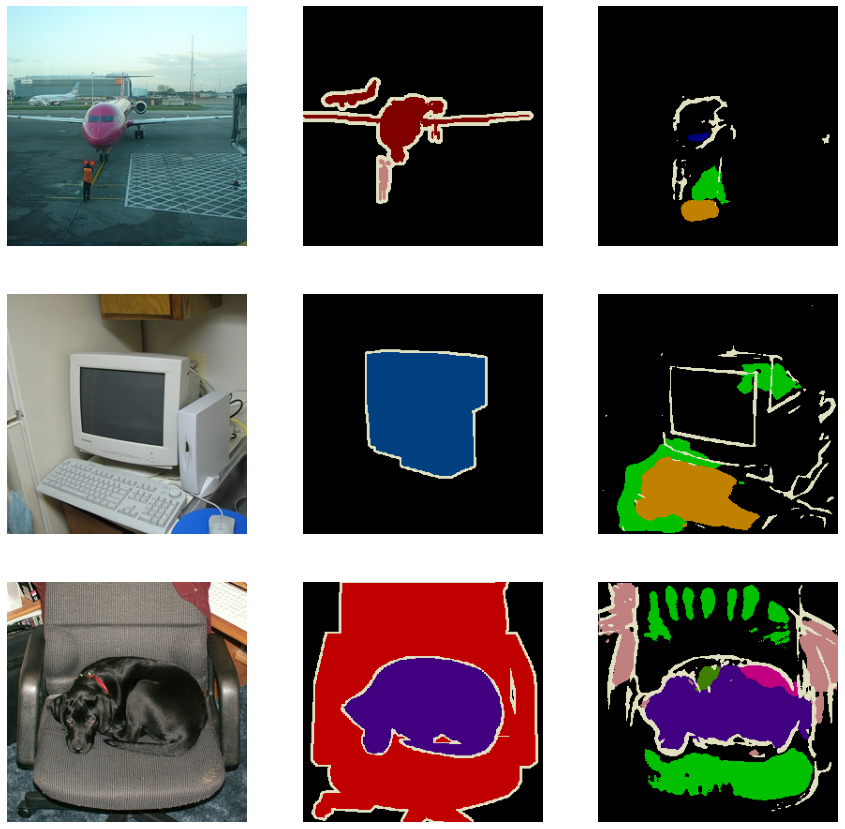

In [259]:
palette = masks[0].getpalette()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[i])
    axes[i, 1].axis('off')
    pred_mask = PIL.Image.fromarray(predicted_masks[i].astype(np.uint8), mode='P')
    pred_mask.putpalette(palette)
    axes[i, 2].imshow(pred_mask)
    axes[i, 2].axis('off')